In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from mymodule.data_stuff import *

In [3]:
from collections import deque
import pickle

def read_all_contexts(context_size=2, verbose=100000):
    with open('./open_subtitles_en_raw') as fin:
        lines = []
        for l in fin:
            lines.append(l.strip())
    contexts = []
    curr_context = deque(lines[:context_size], context_size)
    curr_answer = lines[context_size]
    
    t = 0
    for line in lines[context_size+1:]:
        contexts.append({'context':list(curr_context), 'answer': curr_answer})

        if t % verbose == 0:
            print(t)
        curr_context.append(curr_answer)
        curr_answer = line.strip()

        t += 1
    return contexts

In [4]:
with open('contexts.pkl', 'rb') as fin:
    contexts = pickle.load(fin)

In [5]:
import tqdm

In [7]:
maxlen = 0
for i in tqdm.trange(len(contexts)):
    maxlen = max(len(preprocess(contexts[i]['context'])), maxlen)

100%|██████████| 18845078/18845078 [30:02<00:00, 10453.51it/s]


In [8]:
print maxlen

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-8-a0bf52e124cb>, line 1)

In [ ]:
plt.hist(lens)

In [3]:
contexts[0]

{'answer': 'Hey, Nick.',
 'context': ['Kids can get pretty much anything they want in the yard, as long as they can afford it.',
  "'Cause everything comes with a price."]}

# Actor-Critic Dialogue Model 

**! (symbolic expressions start from here)**

In [16]:
%env THEANO_FLAGS=device=gpu4,floatX=float32,exception_verbosity=high,lib.cnmem=0.8
from warnings import warn
import numpy as np
import theano
import theano.tensor as T
from collections import OrderedDict
import lasagne

env: THEANO_FLAGS=device=gpu4,floatX=float32,exception_verbosity=high,lib.cnmem=0.8


Using gpu device 4: GeForce GTX 1080 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5105)


In [17]:
GRAD_CLIP = 5
N_LSTM_UNITS = 1024
EMB_SIZE = 512
BOTTLENECK_UNITS = 256

TEMPERATURE = theano.shared(np.float32(1.), name='temperature')

## Encoder

* Just convolves sequence of input words into final hidden vector (so outputs [batch_size, N_LSTM_UNITS])

In [18]:
from lasagne.layers import *

class Enc:
    ### THEANO GRAPH INPUT ###
    input_phrase = T.imatrix("encoder phrase tokens")
    ##########################
    
    l_in = InputLayer((None, None), input_phrase, name='context input')
    l_mask = InputLayer((None, None), T.neq(input_phrase, PAD_ix), name='context mask')
    
    l_emb = EmbeddingLayer(l_in, N_TOKENS, EMB_SIZE, name="context embedding")
    
    
    ####LSTMLayer with CORRECT outputgate####
    
    l_lstm = LSTMLayer(l_emb,
                       N_LSTM_UNITS,
                       name='encoder_lstm',
                       grad_clipping=GRAD_CLIP,
                       mask_input=l_mask,
                       only_return_final=True,
                       peepholes=False)
    
    output = l_lstm

## This defines one step of decoder.

* Decoder takes next things as input (at each tick!): ``(prev_cell, prev_hid, inp_word, encoder_output)``
* Decoder makes computations and output: ``(next_cell, next_hid, next_word)`` which will be passed as inputs at the next tick.

In [19]:
from agentnet import Recurrence
from agentnet.resolver import  ProbabilisticResolver
from agentnet.memory import LSTMCell

class Dec:
    # Define inputs of decoder at each time step.
    prev_cell = InputLayer((None, N_LSTM_UNITS), name='cell')
    prev_hid = InputLayer((None, N_LSTM_UNITS), name='hid')
    input_word = InputLayer((None,))
    encoder_lstm = InputLayer((None, N_LSTM_UNITS), name='encoder')

    
    # Embed input word and use the same embeddings as in the encoder.
    word_embedding = EmbeddingLayer(input_word, N_TOKENS, EMB_SIZE,
                                    W=Enc.l_emb.W, name='emb')
    
    
    # This is not WrongLSTMLayer! *Cell is used for one-tick networks.
    new_cell, new_hid = LSTMCell(prev_cell, prev_hid,
                                 input_or_inputs=[word_embedding, encoder_lstm],
                                 name='decoder_lstm',
                                 peepholes=False)
    
    # Define parts for new word prediction. Bottleneck is a hack for reducing time complexity.
    bottleneck = DenseLayer(new_hid, BOTTLENECK_UNITS, nonlinearity=T.tanh, name='decoder intermediate')

    
    next_word_probs = DenseLayer(bottleneck, N_TOKENS,
                                 nonlinearity=lambda probs: T.nnet.softmax(probs/TEMPERATURE),
                                 name='decoder next word probas')

    next_words = ProbabilisticResolver(next_word_probs, assume_normalized=True)

## Generator unrolls decoder for ``n_steps``

* It uses ``Recurrence`` class from ``agentnet``.

* ``theano.scan`` fn takes arguments in order: ``seq1, seq2,..,output1,output2,..,nonseq1,nonseq2,...``
* ``Recurrence`` unrolls ...

In [20]:
class GenTest:
    n_steps = theano.shared(25)
    # This theano tensor is used as first input word for decoder.
    bos_input_var = T.zeros((Enc.input_phrase.shape[0],), 'int32')+BOS_ix
    
    bos_input_layer = InputLayer((None,), bos_input_var, name="first input")

    recurrence = Recurrence(
        # This means that encoder.output passed to decoder.encoder_lstm input at each tick.
        input_nonsequences={Dec.encoder_lstm: Enc.output},
        
        # This defines how outputs moves to inputs at each tick in decoder. 
        # These corresponds to outputs in theano scan function.
        state_variables=OrderedDict([(Dec.new_cell, Dec.prev_cell),
                                     (Dec.new_hid, Dec.prev_hid),
                                     (Dec.next_words, Dec.input_word)]),        
        state_init={Dec.next_words: bos_input_layer},
        n_steps=n_steps,
        unroll_scan=False)
    
    weights = get_all_params(recurrence, trainable=True)
    
    recurrence_outputs = get_output(recurrence)
        
    ##### DECODER UNROLLED #####
    # Theano tensor which represents sequence of generated words.
    words_seq = recurrence_outputs[Dec.next_words]
    
    # Theano tensor which represents decoder hidden states.
    dec_cell_seq = recurrence_outputs[Dec.new_cell]
    ############################
                                                 
    generate = theano.function([Enc.input_phrase], [words_seq, dec_cell_seq],
                               updates=recurrence.get_automatic_updates())
    
    
    @staticmethod
    def reply(phrase, max_len=25, **kwargs):
        old_value = GenTest.n_steps.get_value()
        
        GenTest.n_steps.set_value(max_len)
        phrase_ix = phrase2matrix([phrase],**kwargs)
        answer_ix = GenTest.generate(phrase_ix)[0][0]
        if EOS_ix in answer_ix:
            answer_ix = answer_ix[:list(answer_ix).index(EOS_ix)]
            
        GenTest.n_steps.set_value(old_value)
        return ' '.join(map(tokens.__getitem__, answer_ix))
        

/home/hedgedir/agentnet/agentnet/agent/recurrence.py:595: UserWarning: Warning: recurrent loop without unroll_scan got nonempty random state updates list. That happened because there is some source of randomness (e.g. dropout) inside recurrent step graph. To compile such graph, one must either call .get_automatic_updates() right after .get_output and pass these updates to a function, or use no_defalt_updates=True when compiling theano.function.
  warn("Warning: recurrent loop without unroll_scan got nonempty random state updates list. That happened"


## LM Trainer

In [21]:
class GenTrain:
    """contains a recurrent loop where network is fed with reference answers instead of her own outputs.
    Also contains some functions that train network in that mode."""
    
    ### THEANO GRAPH INPUT. ###
    reference_answers = T.imatrix("decoder reference answers") # shape [batch_size, max_len]
    ###########################
    
    bos_column = T.zeros((reference_answers.shape[0], 1), 'int32')+BOS_ix
    reference_answers_bos = T.concatenate((bos_column, reference_answers), axis=1)  #prepend BOS
    
    l_ref_answers = InputLayer((None, None), reference_answers_bos, name='context input')
    l_ref_mask = InputLayer((None, None), T.neq(reference_answers_bos, PAD_ix), name='context mask')
    
    recurrence = Recurrence(
        input_nonsequences=OrderedDict([(Dec.encoder_lstm, Enc.output)]),
        input_sequences=OrderedDict([(Dec.input_word, l_ref_answers)]),
        state_variables=OrderedDict([(Dec.new_cell, Dec.prev_cell),
                                     (Dec.new_hid, Dec.prev_hid)]),
        tracked_outputs=[Dec.next_word_probs, Dec.next_words],
        mask_input=l_ref_mask,
        unroll_scan=False)
    
    recurrence_outputs = get_output(recurrence)
    
    P_seq = recurrence_outputs[Dec.next_word_probs]
    
    
    ############################
    ###loglikelihood training###
    ############################
    predicted_probas = P_seq[:, :-1].reshape((-1, N_TOKENS))+1e-6
    target_labels = reference_answers.ravel()
    
    llh_loss = lasagne.objectives.categorical_crossentropy(predicted_probas, target_labels).mean()
    
    llh_updates = lasagne.updates.adam(llh_loss, GenTest.weights, 0.001)
    
    train_step = theano.function([Enc.input_phrase, reference_answers], llh_loss,
                                 updates=llh_updates+recurrence.get_automatic_updates())
    get_llh = theano.function([Enc.input_phrase, reference_answers], llh_loss, no_default_updates=True)

/home/hedgedir/agentnet/agentnet/agent/recurrence.py:301: UserWarning: You are giving Recurrence an input sequence of undefined length (None).
Make sure it is always above <unspecified>(n_steps) you specified for recurrence
  "Make sure it is always above {}(n_steps) you specified for recurrence".format(n_steps or "<unspecified>"))
/home/hedgedir/agentnet/agentnet/agent/recurrence.py:595: UserWarning: Warning: recurrent loop without unroll_scan got nonempty random state updates list. That happened because there is some source of randomness (e.g. dropout) inside recurrent step graph. To compile such graph, one must either call .get_automatic_updates() right after .get_output and pass these updates to a function, or use no_defalt_updates=True when compiling theano.function.
  warn("Warning: recurrent loop without unroll_scan got nonempty random state updates list. That happened"


### Training loop

In [22]:
from agentnet.utils.persistence import save,load
# load(GenTest.recurrence,"pretrained_network/weights.pcl")

In [23]:
def iterate_minibatches(batch_size=64):
    total_batches = len(contexts)//batch_size
    for b in range(total_batches):
        excerpt = contexts[b*batch_size:(b+1)*batch_size]
        excerpt_context = [item['context'] for item in excerpt]
        excerpt_answer = [item['answer'] for item in excerpt]
        yield phrase2matrix(excerpt_context), phrase2matrix(excerpt_answer)
        
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

test_phrases = [['Hello! How are you?'],
                ['How old are you?'],
                ['Are you fucking kidding me?'],
                ['Suck. What are you doing?'], 
                ['You are piece of shit!!!'], 
                ['holy fucking crap. you are motherfucker']]


BATCH_SIZE = 128
N_EPOCHS = 100
VERBOSITY = 10 # number of batches before printing
NUM_BATCHES = len(contexts)//BATCH_SIZE

SAVE_EVERY = 500

f_log = open('log.txt', 'w')
WEIGHTS_FILE = 'weights/LM_small.pkl'

In [13]:
load(GenTest.recurrence, WEIGHTS_FILE)

In [ ]:
loss_history = []
# with open('loss_history.pkl', 'rb') as fin:
#     loss_history = pickle.load(fin)

In [ ]:
for n_epoch in range(N_EPOCHS):
    for nb,batch in enumerate(iterate_minibatches(BATCH_SIZE)):
        ## Saving stuff.
        if (n_epoch*NUM_BATCHES + nb + 1) % SAVE_EVERY == 0:
            save(GenTest.recurrence, WEIGHTS_FILE)
            f_log.write("\nSAVED WEIGHTS!!!\n")
        
        ## Printing stuff.
        if (n_epoch*NUM_BATCHES + nb + 1) % VERBOSITY == 0:
            clear_output(wait=True)
            f_log.write("Processed {}/{} epochs and {}/{} batches in current epoch\n".format(n_epoch, N_EPOCHS,
                                                                                     nb+1, NUM_BATCHES))
            f_log.write("Loss (averaged with last 10 batches): {0:.5f}\n".format(np.mean(loss_history[-10:])))
            print("Loss:\t{:.4f}".format(np.mean(loss_history[-10:])))
            
            f_log.write("Answers on test phrases:\n")

            for i in range(len(test_phrases)):
                f_log.write("Phrase:\t{}\n".format(test_phrases[i]))
                f_log.write("Answer:\t{}\n".format(GenTest.reply(test_phrases[i])))
                f_log.write('---'*5+'\n')
            f_log.write('****'*10+'\n')
            
            f_log.flush()
            
            with open('loss_history.pkl', 'wb') as fout:
                pickle.dump(loss_history, fout)
        
        ## Training stuff.
        batch_loss = GenTrain.train_step(batch[0], batch[1])
    
        loss_history.append(batch_loss)

Loss:	8.5311


# Critic

**Actor-Critic part**:
* Decoder also tries to evaluate **V-function** at each tick. **State** is hidden cell of LSTM layer.
* As a reward for being in state `s` and generating word `a` we take 1 if word `a` is obscene, 0 otherwise.

* During training, we can compute these rewards trivially (we just need to collect a dictionary of obscene words).
* We use TD updates [V(s) = V(s) + alpha \* (R + V(s') - V(s))]; for function approximation, its equivalent to ``new_weights = old_weights - alpha * grad(MSE(targetV, approxV), old_weights)``

In [78]:
class Critic:
    l_dec_cell = InputLayer((None, N_LSTM_UNITS), name='l_decoder_cell') # shape [batch_size, N_LSTM_UNITS]
    
    ### THEANO GRAPH INPUT. ###
    dec_cell_seq = T.tensor3('decoder hidden cell sequence after recurrence') # shape [batch_size, n_steps, N_LSTM_UNITS]
    ###########################
    
    l_dec_cell_seq = InputLayer((None, None, N_LSTM_UNITS), input_var=dec_cell_seq, name='l_decoder_cell_sequence')
    
    l_critic_values = DenseLayer(l_dec_cell, num_units=512, name="CRITIC__dense1")
    l_critic_values = DenseLayer(l_critic_values, num_units=256, name="CRITIC_dense2")
    l_critic_values = DenseLayer(l_critic_values, num_units=1, nonlinearity=None, name='CRITIC__values')
    
    recurrence = Recurrence(
        input_sequences={l_dec_cell: l_dec_cell_seq},
        tracked_outputs=[l_critic_values],
        unroll_scan=False,
        n_steps=GenTest.n_steps
    )
    
    rec_outputs = get_output(recurrence)
    
    critic_values_seq = rec_outputs[l_critic_values]
    # Now its shape [batch, n_steps, 1]. Reshape it to [batch, n_steps]
    old_shape = critic_values_seq.shape
    critic_values_seq = critic_values_seq.reshape((old_shape[0], old_shape[1]))
    
    predict = theano.function([dec_cell_seq], critic_values_seq, allow_input_downcast=True)
    
    weights = get_all_params(l_critic_values, trainable=True)

/home/hedgedir/agentnet/agentnet/agent/recurrence.py:301: UserWarning: You are giving Recurrence an input sequence of undefined length (None).
Make sure it is always above <TensorType(int64, scalar)>(n_steps) you specified for recurrence
  "Make sure it is always above {}(n_steps) you specified for recurrence".format(n_steps or "<unspecified>"))


In [79]:
from agentnet.learning.generic import get_n_step_value_reference
from theano.gradient import disconnected_grad

class CriticTrainer:
    td_n_steps = 3
    
    # We will obtain these values from calc_rewards() function.
    rewards = T.matrix(name='rewards for each generated word') # shape [batch_size, n_steps]
    is_alive = T.imatrix(name='is alive mask') # shape [batch_size, n_steps]
    
    V_predicted = Critic.critic_values_seq
    
    V_reference = get_n_step_value_reference(state_values=V_predicted,
                                             rewards=rewards,
                                             is_alive=is_alive,
                                             n_steps=td_n_steps)
    
    # We must not propagate grads through target value (semi-gradient method).
    V_reference = disconnected_grad(V_reference)
    
    td_loss = lasagne.objectives.squared_error(V_predicted, V_reference).mean()
    td_updates = lasagne.updates.adam(td_loss, Critic.weights)
    
    train_step = theano.function([rewards, is_alive, Critic.dec_cell_seq], td_loss,
                                 updates=td_updates,
                                 allow_input_downcast=True)
    
    
CT = CriticTrainer

## Critic training

__How do we train critic?__
* Iterating over batches of data (it will be `Enc.input_phrase`)
* Generating `GenTest.words_seq, GenTest.dec_cell_seq`.
* Computing rewards and is_alive mask using `GenTest.words_seq`
* Propagating gradients to critic calling `CT.train_step(rewards, is_alive, dec_cell_seq)`.

That's it! Simple.

## Here we define how rewards are calculated based on generated sequences.

__Let's load obscene words list first__

In [82]:
with open('./obscene_words.txt') as fin:
    target_words = set()
    for line in fin:
        words_in_line = line.strip().split()
        if len(words_in_line) == 1:
            target_words.update(words_in_line)
            
target_words.add('suck')
target_words.add('goddamn')
target_words.add('motherfucker')
target_words.add('nigger')
target_words.add('nigga')
target_words.add('ass')
target_words.add('crap')
target_words.add('fucking')

print("Some examples %s" % list(target_words)[:10])

target_idxs = set(filter(lambda x: x != UNK_ix, [token2idx[w] for w in target_words]))

print("Number of target words %d" % len(target_idxs))

Some examples ['bitch', 'niggaz', 'shitdick', 'penis', 'sh!t', 'fuckwhit', 'knobead', 'nigger', 'nobjocky', 'pissin']
Number of target words 154


In [81]:
def calc_rewards(generated_batch):
    assert generated_batch.ndim == 2
    rewards = np.zeros_like(generated_batch)
    is_alive = np.zeros_like(generated_batch, dtype=np.int32)
    
    for i in range(generated_batch.shape[0]):
        for j in range(generated_batch.shape[1]):
            if generated_batch[i][j] == EOS_ix:
                break
            if generated_batch[i][j] in target_idxs:
                rewards[i][j] = 1
            is_alive[i][j] = 1
    return rewards, is_alive

## Training

In [75]:
with open('contexts.pkl', 'rb') as fin:
    contexts = pickle.load(fin)

In [146]:
contexts[0]

{'answer': 'Hey, Nick.',
 'context': ['Kids can get pretty much anything they want in the yard, as long as they can afford it.',
  "'Cause everything comes with a price."]}

In [19]:
def iterate_minibatches(batch_size=64):
    total_batches = len(contexts)//batch_size
    for b in range(total_batches):
        excerpt = contexts[b*batch_size:(b+1)*batch_size]
        excerpt = [item['context'] for item in excerpt]
        yield phrase2matrix(excerpt)

In [20]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [83]:
test_phrases = [['Hello! How are you?'],
                ['How old are you?'],
                ['Are you fucking kidding me?'],
                ['Suck. What are you doing?'], 
                ['You are piece of shit!!!'], 
                ['holy fucking crap. you are motherfucker']]

test_phrases_ids = phrase2matrix(test_phrases)

Processed 0/100 epochs and 660/36806 batches in current epoch
Loss (averaged with last 10 batches): 0.00164
Avg reward: 0.00095
Loss history:


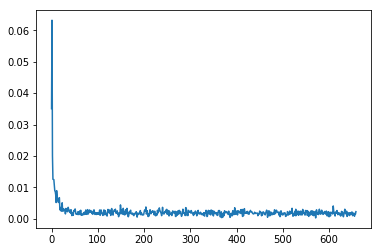

Answers on test phrases:
Phrase:	 ['Hello! How are you?']
Answer:	
"i"(0.013) 
"'"(0.010) 
"m"(0.010) 
"not"(0.008) 
"welcome"(0.012) 
"."(0.005) 
---------------
Phrase:	 ['How old are you?']
Answer:	
"i"(0.015) 
"'"(0.014) 
"m"(0.010) 
"11"(0.010) 
"."(0.005) 
---------------
Phrase:	 ['Are you fucking kidding me?']
Answer:	
"all"(0.048) 
"right"(0.012) 
","(0.006) 
"you"(0.029) 
"ready"(0.065) 
"for"(0.046) 
"the"(0.007) 
"rod"(0.017) 
"!"(0.005) 
---------------
Phrase:	 ['Suck. What are you doing?']
Answer:	
"it"(0.040) 
"'"(0.010) 
"s"(0.010) 
"something"(0.012) 
"you"(0.005) 
"like"(0.008) 
"?"(0.007) 
---------------
Phrase:	 ['You are piece of shit!!!']
Answer:	
"have"(0.045) 
"a"(0.014) 
"sharper"(0.011) 
"intervention"(0.007) 
","(0.005) 
"doc"(0.015) 
"."(0.006) 
---------------
Phrase:	 ['holy fucking crap. you are motherfucker']
Answer:	
"really"(0.050) 
"?"(0.018) 
---------------


KeyboardInterrupt: 

In [84]:
BATCH_SIZE = 512
N_EPOCHS = 100
VERBOSITY = 10 # number of batches before printing
NUM_BATCHES = len(contexts)//BATCH_SIZE


loss_history = []
rewards_history = []
for n_epoch in range(N_EPOCHS):
    for nb,batch in enumerate(iterate_minibatches(BATCH_SIZE)):
        ## Printing stuff.
        if (n_epoch*NUM_BATCHES + nb + 1) % VERBOSITY == 0:
            clear_output(wait=True)
            print("Processed {}/{} epochs and {}/{} batches in current epoch".format(n_epoch, N_EPOCHS,
                                                                                     nb+1, NUM_BATCHES))
            print("Loss (averaged with last 10 batches): {0:.5f}".format(np.mean(loss_history[-10:])))
            print("Avg reward: {0:.5f}".format(np.mean(rewards_history[-10:])))
            print("Loss history:")
            plt.plot(loss_history)
            plt.show()
            
            print("Answers on test phrases:")
            words_seq, dec_cell_seq = GenTest.generate(test_phrases_ids)
            critic_values = Critic.predict(dec_cell_seq)
            
            answers = []
            for i in range(words_seq.shape[0]):
                answer = words_seq[i]
                if EOS_ix in answer:
                    answer = answer[:list(answer).index(EOS_ix)]
                answers.append([tokens[idx] for idx in answer])
            
            for i in range(len(test_phrases)):
                print("Phrase:\t", test_phrases[i])
                answer_tok_critic_value = zip(answers[i], critic_values[i])
                print("Answer:\t",)
                for tok,value in answer_tok_critic_value:
                    print('"{}"({:.3f}) '.format(tok, value),)
                print('---'*5)
            
        
        ## Training stuff.
        words_seq, dec_cell_seq = GenTest.generate(batch)
        
        rewards, is_alive = calc_rewards(words_seq)
        
        batch_loss = CriticTrainer.train_step(rewards, is_alive, dec_cell_seq)
        
        loss_history.append(batch_loss)
        rewards_history.append(np.mean(rewards))

## Some answer generations

In [74]:
TEMPERATURE.set_value(np.float32(0.5))
for i in range(5):
    print(GenTest.reply(["what is your favorite show?"], 20))
    
TEMPERATURE.set_value(np.float32(1))

i ' m not a fan of the play .
i don ' t know .
the video .
uh , uh , i ' m just gonna go with the . . .
that is . . .


In [105]:
import lasagne 
class trainer:
    """contains a recurrent loop where network is fed with reference answers instead of her own outputs.
    Also contains some functions that train network in that mode."""
    #training recurrence
    reference_answers = T.imatrix("decoder reference answers")
    
    bos_column = T.zeros((reference_answers.shape[0], 1), 'int32')+BOS_ix
    reference_answers_bos = T.concatenate((bos_column, reference_answers ), axis=1)  #prepend BOS
        
    l_ref = InputLayer((None, None), reference_answers_bos, name='context input')
    l_ref_mask = InputLayer((None, None), T.neq(reference_answers_bos, PAD_ix),'context mask')

    recurrence = Recurrence(input_sequences={decoder.inp_word: l_ref},
                            input_nonsequences={decoder.encoder_lstm: encoder.output},
                            state_variables={decoder.new_cell: decoder.prev_cell,
                                             decoder.new_hid: decoder.prev_hid},
                            tracked_outputs=[decoder.next_word_probs],#<ADDWHATEVERYOUWANT>,]
                            mask_input=l_ref_mask,
                            unroll_scan=False)
    
    
    P_seq = get_output(recurrence[decoder.next_word_probs])
    #V_seq = whateveryouadded
    
    ############################
    ###loglikelihood training###
    ############################
    predicted_probas = P_seq[:, :-1].reshape((-1, N_TOKENS))+1e-6
    target_values = reference_answers.ravel()
    llh = lasagne.objectives.categorical_crossentropy(predicted_probas, target_values)
    llh_loss = llh.mean()

    #only train over generator weights since state value estimator does not influence likelihood (disconnected)
    llh_updates = lasagne.updates.adam(llh_loss, generator.weights, 0.001)

    train_llh_step = theano.function([encoder.input_phrase, reference_answers], llh_loss, updates=llh_updates)
    get_llh = theano.function([encoder.input_phrase, reference_answers], llh)

    


/home/hedgedir/agentnet/agentnet/agent/recurrence.py:188: UserWarning: State_variables recommended type is OrderedDict.
                Otherwise, order of agent state outputs from get_sessions and get_agent_reaction methods
                may depend on python configuration.

                Current order is: [<lasagne.layers.merge.ElemwiseMergeLayer object at 0x7f0176a7cc88>, <lasagne.layers.special.NonlinearityLayer object at 0x7f0176a7cc50>]
                You may find OrderedDict in standard collections module: from collections import OrderedDict
                
  """.format(state_variables=list(self.state_variables.keys())))
/home/hedgedir/agentnet/agentnet/agent/recurrence.py:301: UserWarning: You are giving Recurrence an input sequence of undefined length (None).
Make sure it is always above <unspecified>(n_steps) you specified for recurrence
  "Make sure it is always above {}(n_steps) you specified for recurrence".format(n_steps or "<unspecified>"))
INFO (theano.gof.compilel